In [1]:
import feed
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from tqdm.notebook import tqdm

## 重新，此次方向為：
    * 先將各Factors以企業中心化來調整後，再計算分數為高或低
    * 方法是: a. 單一公司與過去相比目前是高是低 b. 單一公司與整個行業相比是高是低

流程:
    1. 抓一張大表

In [2]:
def init():
    pd.options.plotting.backend = "matplotlib"
    plt.rcParams['font.family'] = ['Microsoft JhengHei']  # 中文標籤
    plt.rcParams['axes.unicode_minus'] = False  # 負號
    pd.set_option('display.max_rows', 20)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    pd.options.display.float_format = '{:,.4f}'.format


def add_factors(name, df, stk_len, stk_num, func):
    new_col = list(zip([name]*stk_len, stk_num))
    new_df = eval(func)
    new_df.columns = new_col
    new_df = new_df.replace([np.inf, -np.inf, np.nan],
                            0).mask(new_df > 5, 5).mask(new_df < -5, -5)
    df = pd.concat([df, new_df], axis=1)
    return df


def calculate_value(df, dic, data_list, reverse_list, stk_len, stk_num):
    # 行業名稱
    df_value = copy.deepcopy(df)
    for sname in dic['指數彙編'].iloc[:, 0].unique():
        # 由行業名稱選定股票代碼
        symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0]
                              == sname].iloc[:, -2].astype(str).values
        # 從大表中提取單一行業中所有股票的單一Factor

        for factor in data_list:  # 這邊沒再對MA做比較(這樣額外Factors都不會做比較)
            table = df.loc[:, factor].loc[:, symbols].fillna(method='ffill')
            # 計算單一個股目前資料水準
            table1 = (table - table.rolling(500).mean()) / \
            table.rolling(500).std()
            # 計算行業中心目前資料水平
            table2 = table.subtract(table.mean(axis=1), axis=0).divide(
                table.std(axis=1), axis=0)
            # 處理錯誤值與極端值
            table1.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
            table2.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
            table1 = table1.mask(table1 > 5, 5).mask(table1 < -5, -5)
            table2 = table2.mask(table2 > 5, 5).mask(table2 < -5, -5)
            # 個別與行業相加
            ta = table1+table2
            ta.columns = list(zip([factor]*len(table.columns), table.columns))
            df_value.loc[:, ta.columns] = ta

    # 先將反向的乘上-1
    reverse = reverse_list
    for re in reverse:
        col = list(zip([re]*stk_len, stk_num))
        df_value.loc[:, col] = df_value.loc[:, col] * -1
    return df_value

    # 計算合計分數


def calculate_scores(df_value, stk_idx, stk_num, **params):
    scores = pd.DataFrame(index=stk_idx, columns=stk_num).fillna(0)
    for d in df_value.columns.get_level_values(0).unique():
        scores += df_value[d] * params[d]
    return scores


def backtesting(df, scores, bins, stk_idx, stk_num, ls: str='onlylong', pplot: bool=False, freq='D', init_cash: int=10000000, returnbs: bool=False):
    return_df = list()
    # long = dict()
    # short = dict()
    bins = bins
    labels = [str(i) for i in range(1, bins+1)]
    rt = df['還原收盤價'].shift(-1).groupby(pd.Grouper(freq=freq)).tail(
        1).pct_change().shift(-1).replace([np.inf, -np.inf, np.nan], 0)
    bs_l = pd.DataFrame(index=stk_idx, columns=stk_num).fillna(
        0).groupby(pd.Grouper(freq=freq)).tail(1)
    if ls != 'onlylong':
        bs_s = pd.DataFrame(index=stk_idx, columns=stk_num).fillna(
            0).groupby(pd.Grouper(freq=freq)).tail(1)

    for idx, row in scores.groupby(pd.Grouper(freq=freq)).tail(1).iterrows():
        try:
            bs_l.loc[idx, row[pd.cut(row, bins=bins, labels=labels)
                            == labels[-1]].index.values] = 1
            if ls != 'onlylong':
                bs_s.loc[idx, row[pd.cut(row, bins=bins, labels=labels)
                                == labels[0]].index.values] = -1
        # long[idx] = row[pd.cut(row, bins=bins, labels=labels)
        #                 == labels[-1]].index.values
        # short[idx] = row[pd.cut(row, bins=bins, labels=labels)
        #                 == labels[0]].index.values
        except:
            pass
        if pplot:
            se = rt.loc[idx].groupby(pd.cut(row, bins=bins, labels=labels)).mean()
            return_df.append(se)
    if pplot:
        return_df = pd.concat(return_df, axis=1).T
        return_df.cumsum().plot(figsize=(16, 9)).plot(title='Bins Return')
        plt.show()

    per_cash = init_cash / bs_l.sum(axis=1)
    # long
    bs_l_share = copy.deepcopy(bs_l)
    for idx, row in bs_l.iterrows():
        bs_l_share.loc[idx, row[row > 0].index] = (per_cash.at[idx] / df['還原收盤價'].fillna(
            method='ffill').loc[idx, row[row > 0].index] / 1000).replace([np.inf, -np.inf, np.nan], 0).astype(int)
    bs_l_daily = pd.DataFrame(index=stk_idx, columns=stk_num)
    bs_l_daily.loc[bs_l_share.index, bs_l_share.columns] = bs_l_share
    bs_l_daily.fillna(method='ffill', inplace=True)
    bs_l_daily = bs_l_daily.shift(1)
    diff = bs_l_daily.diff()
    cost = ((diff[diff > 0].shift(1).fillna(0) *
            df['還原收盤價']*0.001425)*1000).fillna(0)
    cost -= ((diff[diff < 0].fillna(0)*df['還原收盤價']*0.004425)*1000).fillna(0)
    pf_l_daily = bs_l_daily * \
        df['還原收盤價'].fillna(method='ffill').diff().shift(-1)*1000
    pf_l_daily_minus_cost = pf_l_daily - cost

    if ls != 'onlylong':
        bs_s_share = copy.deepcopy(bs_s)
        for idx, row in bs_s.iterrows():
            bs_s_share.loc[idx, row[row < 0].index] = (per_cash.at[idx] / df['還原收盤價'].fillna(
                method='ffill').loc[idx, row[row < 0].index] / 1000).replace([np.inf, -np.inf, np.nan], 0).astype(int)
        bs_s_daily = pd.DataFrame(index=stk_idx, columns=stk_num)
        bs_s_daily.loc[bs_s_share.index, bs_s_share.columns] = -1 * bs_s_share
        bs_s_daily.fillna(method='ffill', inplace=True)
        bs_s_daily = bs_s_daily.shift(1)
        diff = bs_s_daily.diff()
        cost = ((diff[diff > 0].shift(1).fillna(0) *
                df['還原收盤價']*0.001425)*1000).fillna(0)
        cost -= ((diff[diff < 0].fillna(0)*df['還原收盤價']*0.004425)*1000).fillna(0)
        pf_s_daily = bs_s_daily * \
            df['還原收盤價'].fillna(method='ffill').diff().shift(-1)*1000
        pf_s_daily_minus_cost = pf_s_daily - cost



    if ls == 'onlylong':
        sortino = ((250 * pf_l_daily_minus_cost.sum(axis=1).mean()) / (pf_l_daily_minus_cost.sum(axis=1)
                [pf_l_daily_minus_cost.sum(axis=1) < 0].std() * np.sqrt(250))).mean()
    else:
        pf_minus_cost = pf_l_daily_minus_cost + pf_s_daily_minus_cost
        sortino = ((250 * pf_minus_cost.sum(axis=1).mean()) / (pf_minus_cost.sum(axis=1)
                [pf_minus_cost.sum(axis=1) < 0].std() * np.sqrt(250))).mean()
    if pplot:
        if ls == 'onlylong':
            pf_l_daily_minus_cost.sum(axis=1).cumsum().plot(title=f'Sortino: {sortino:.2f}', figsize=(16, 9))
        else:
            pf_minus_cost.sum(axis=1).cumsum().plot(title=f'Sortino: {sortino:.2f}', figsize=(16, 9))
        plt.show()
    if returnbs:
        if ls != 'onlylong':
            return bs_l_daily, bs_s_daily, sortino
        else:
            return bs_l_daily, sortino
    else:
        return sortino
    



In [3]:
# , '資產總計_Q', '負債總計_Q', '現金股利殖利率_Q'
if __name__ == '__main__':
    init()
    data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價',
                 'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
    start = datetime.datetime(2004, 1, 1)
    end = datetime.datetime.today()
    data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
    dic = feed.get_from_mongo(elements=data2_list, db='Index')

    df_params = {
        'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
        '本益比(近四季)': '.mask(data>100, 100)',
        '殖利率': '.mask(data>100, 100)'
    }
    df = feed.get_from_mongo(
        elements=data_list,
        db='Fields',
        symbols=[],
        start=start,
        end=end,
        concat=True,
        ffill=['EPS_Q', '營業收入淨額_Q'],
        zscore=[],
        **df_params)
    # 抓完資料後有些資料會因為fill重複(推估來自於Q轉D)，因此要先調整到正確日期，這邊我選還原收盤價來當作正確日期標準
    df = df.loc[df['還原收盤價'].drop_duplicates().index]

    stk_num = df['還原收盤價'].columns
    stk_len = len(stk_num)
    stk_idx = df['還原收盤價'].index

    # 增加額外Factors
    df = add_factors(name='MA60_diff',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="(df['還原收盤價'] - df['還原收盤價'].rolling(60).mean()) / df['還原收盤價'].rolling(60).std()")
    df = add_factors(name='MA120_diff',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="(df['還原收盤價'] - df['還原收盤價'].rolling(120).mean()) / df['還原收盤價'].rolling(120).std()")
    df = add_factors(name='5MOM',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="(df['還原收盤價'] - df['還原收盤價'].shift(5)) / df['還原收盤價'].shift(5)")
    df = add_factors(name='30MOM',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="(df['還原收盤價'] - df['還原收盤價'].shift(5)) / df['還原收盤價'].shift(5)")
    df = add_factors(name='5std',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="df['還原收盤價'].rolling(5).std()")
    df = add_factors(name='30std',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="df['還原收盤價'].rolling(30).std()")
    df = add_factors(name='bias',
                     df=df, stk_len=stk_len, stk_num=stk_num,
                     func="pd.DataFrame(np.random.randint(-5,5, size=(len(df.index), stk_len)), \
                     index=df['還原收盤價'].index, columns=df['還原收盤價'].columns)")
    data_list.extend(['5MOM', '30MOM', 'bias', '5std', '30std'])

    reverse_list = ['本益比(近四季)', '股價淨值比', '5std', '30std']

    # opt_params = {
    #     '本益比(近四季)': 1,
    #     '股價淨值比': 1,
    #     '成交金額(千)': 1,
    #     '還原收盤價': 1,
    #     'EPS_Q': 1,
    #     '營業收入淨額_Q': 1,
    #     '殖利率': 1,
    #     '總市值(億)': 1,
    #     'MA60_diff': 1,
    #     'MA120_diff': 1,
    #     'bias': 0
    # }
    opt_params = {k: 1 for k in df.columns.get_level_values(0).unique()}
    
    df_value = calculate_value(
        df=df, dic=dic, data_list=data_list, 
        reverse_list=reverse_list, stk_len=stk_len, stk_num=stk_num)

    scores = calculate_scores(
        df_value=df_value, stk_idx=stk_idx, stk_num=stk_num, **opt_params)
        



Data TWA00 has shape (6054, 34)
Data 指數彙編 has shape (2211, 8)
Data 指數名稱轉換 has shape (1, 22)
Data 本益比(近四季) has shape (4676, 2211)
Data 股價淨值比 has shape (4676, 2211)
Data 成交金額(千) has shape (4676, 2211)
Data 還原收盤價 has shape (4676, 2211)
Data EPS_Q has shape (76, 2211)
Data 營業收入淨額_Q has shape (76, 2211)
Data 殖利率 has shape (4676, 2211)
Data 總市值(億) has shape (4676, 2211)


In [4]:
opt_params

{'本益比(近四季)': 1,
 '股價淨值比': 1,
 '成交金額(千)': 1,
 '還原收盤價': 1,
 'EPS_Q': 1,
 '營業收入淨額_Q': 1,
 '殖利率': 1,
 '總市值(億)': 1,
 'MA60_diff': 1,
 'MA120_diff': 1,
 '5MOM': 1,
 '30MOM': 1,
 '5std': 1,
 '30std': 1,
 'bias': 1}

### 最佳化參數

In [5]:
def optimize(
    df, dic, data_list, reverse_list, 
    freq='W',
    epochs: int=10, 
    test_rate: float=0.3, 
    random_pick: int=3, 
    rate=0.01, **params):

    # opt_params = {
    #     '本益比(近四季)': 1,
    #     '股價淨值比': 1,
    #     '成交金額(千)': 1,
    #     '還原收盤價': 1,
    #     'EPS_Q': 1,
    #     '營業收入淨額_Q': 1,
    #     '殖利率': 1,
    #     '總市值(億)': 1,
    #     'MA60_diff': 1,
    #     'MA120_diff': 1,
    #     'bias': 0,
    # }
    opt_params = {k: 1 for k in df.columns.get_level_values(0).unique()}
    
    if 'bins' in params:
        bins = params['bins']
    else:
        bins = 10

    if 'init_cash' in params:
        init_cash = params['init_cash']
    else:
        init_cash = 10000000

    if 'ls' in params:
        ls = params['ls']
    else:
        ls = 'onlylong'

    init_params = copy.deepcopy(opt_params)
    dx = copy.deepcopy(opt_params)
    best_params = copy.deepcopy(opt_params)


    stk_num = df['還原收盤價'].columns
    stk_len = len(stk_num)
    stk_idx = df['還原收盤價'].index

    first_idx = df.index[:int(len(df.index)*0.3)]
    train_idx = df.index[:int(len(df.index)*test_rate)]
    test_idx = df.index[int(len(df.index)*test_rate):]

    def bt(opt_params, idx, ls='onlylong', pplot=False):
        df_value = calculate_value(
            df=df.loc[idx], dic=dic, data_list=data_list, 
            reverse_list=reverse_list, stk_len=stk_len, stk_num=stk_num)
        scores = calculate_scores(
            df_value=df_value, stk_idx=idx, stk_num=stk_num, **opt_params)
        
        sortino = backtesting(df.loc[idx], scores=scores, bins=bins, stk_idx=idx, stk_num=stk_num, freq=freq, init_cash=init_cash, pplot=pplot, ls=ls)
        return sortino
    sortino = bt(opt_params, first_idx, ls=ls)
    best_sortino = sortino

    for k in opt_params.keys():
        opt_params[k] -= 0.05

        dx[k] = (bt(opt_params, first_idx, ls=ls) - sortino) * 20

    opt_params = init_params
    sortino_list = list()
    with tqdm(total=epochs, desc='OPT') as pbar:
        for _ in range(epochs):
            pick = random.choices(list(opt_params.keys()), k=random_pick)
        
            init_params = copy.deepcopy(opt_params)
            for p in pick:
                opt_params[p] -= rate * dx[p]
            
            sortino_new = bt(opt_params, train_idx, ls=ls)

            for p in pick:
                dx[p] = sortino_new - sortino

            if sortino_new > best_sortino:
                best_params = opt_params
                best_sortino = sortino_new
            else:
                opt_params = copy.deepcopy(init_params)

            sortino = sortino_new
            sortino_list.append(sortino)
            pbar.set_postfix({'Sortino': f'{sortino:.2f}', 'Best': f'{best_sortino:.2f}'})
            pbar.update(1)
        
    test_sortino = bt(best_params, test_idx, pplot=True, ls=ls)
    return best_params, best_sortino, test_sortino, sortino_list



## 梯度下降最佳化

OPT:   0%|          | 0/700 [00:00<?, ?it/s]

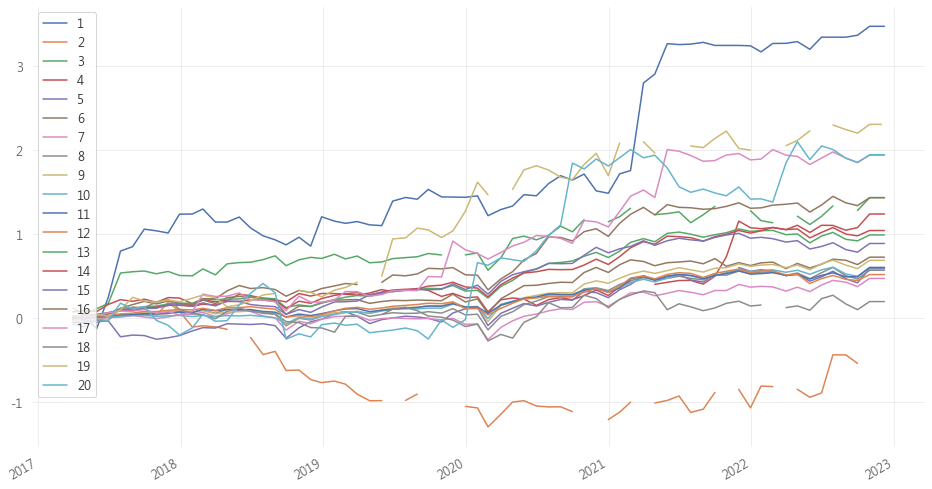

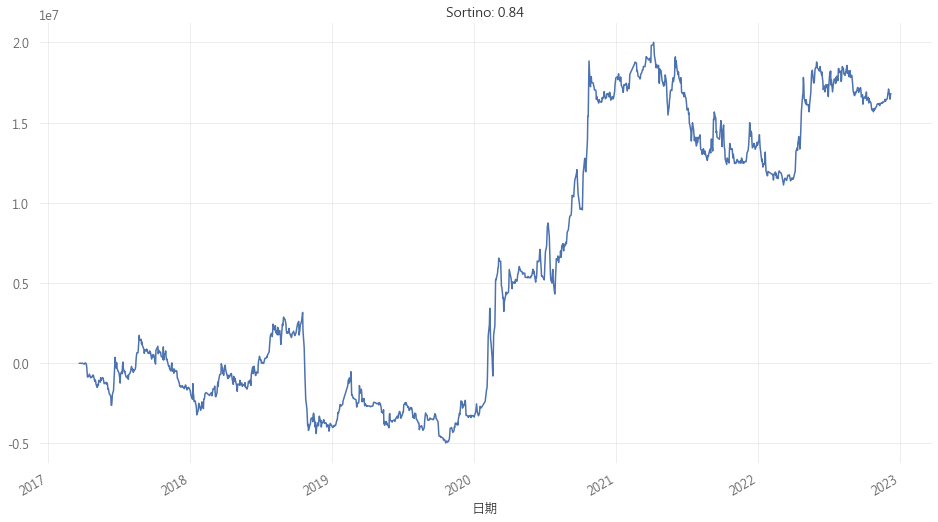

In [6]:
best_param, best_sortino, test_sortino, sortino_list = optimize(
    df=df, dic=dic, data_list=data_list, reverse_list=reverse_list,
    freq='M',
    epochs=700,
    test_rate=0.7,
    random_pick=5,
    rate=0.25,
    bins=20,
    init_cash=10000000,
    ls='onlylong'
)

In [7]:
# 月數據
only_long_param = {'本益比(近四季)': 1.021362714091636,
 '股價淨值比': 0.5121145869760193,
 '成交金額(千)': 0.7484115655592523,
 '還原收盤價': 1,
 'EPS_Q': 0.9950647747119057,
 '營業收入淨額_Q': 1.3058262641416858,
 '殖利率': 1.1931765252200215,
 '總市值(億)': 1.0811175693980957,
 'MA60_diff': 1.0124537353003285,
 'MA120_diff': 0.9835954584302027,
 '5MOM': 0.9914532036507663,
 '30MOM': 1.0016305890666726,
 '5std': 0.6864844950548503,
 '30std': 0.9919228516252319,
 'bias': 0.9901223305062686}

In [46]:
# 週數據
only_long_param ={'本益比(近四季)': 1.0037902482891339,
 '股價淨值比': 1.0170827644854357,
 '成交金額(千)': 1.142589658767339,
 '還原收盤價': 1.0070430242234014,
 'EPS_Q': 0.8926171579327218,
 '營業收入淨額_Q': 1.1710003838295324,
 '殖利率': 0.48429913735776703,
 '總市值(億)': 1.0025106784327664,
 'MA60_diff': 1.027973761957683,
 'MA120_diff': 0.8600043476287066,
 '5MOM': 1.517465624089674,
 '30MOM': 1.0343877327181805,
 '5std': 0.8552166373776005,
 '30std': 1.0267510130763282,
 'bias': 0.9981222505844016}

{'本益比(近四季)': 0.9993523489547684,
 '股價淨值比': 0.9595422161763925,
 '成交金額(千)': 0.8424893427257,
 '還原收盤價': 0.8925366292553363,
 'EPS_Q': 0.841302233957531,
 '營業收入淨額_Q': 0.9991330669383092,
 '殖利率': 0.9759203083372735,
 '總市值(億)': 0.8512510479210453,
 'MA60_diff': 1.0119899789112945,
 'MA120_diff': 0.9994025430126006}

In [48]:
save_param = {'本益比(近四季)': 0.9993523489547684,
 '股價淨值比': 0.9595422161763925,
 '成交金額(千)': 0.8424893427257,
 '還原收盤價': 0.8925366292553363,
 'EPS_Q': 0.841302233957531,
 '營業收入淨額_Q': 0.9991330669383092,
 '殖利率': 0.9759203083372735,
 '總市值(億)': 0.8512510479210453,
 'MA60_diff': 1.0119899789112945,
 'MA120_diff': 0.9994025430126006}

In [6]:
best_param

{'本益比(近四季)': 0.9097931711520725,
 '股價淨值比': 1.0402317352073513,
 '成交金額(千)': 1,
 '還原收盤價': 0.9926249813485397,
 'EPS_Q': 0.9898259018148656,
 '營業收入淨額_Q': 0.9698603271478277,
 '殖利率': 1.008254299779812,
 '總市值(億)': 0.8210958125641377,
 'MA60_diff': 0.7869196890626476,
 'MA120_diff': 0.9870628149912473,
 '5MOM': 1.0143797241731372,
 '30MOM': 1,
 '5std': 1.005743062993816,
 '30std': 1.0094963379738506,
 'bias': 0.9987645957290197}

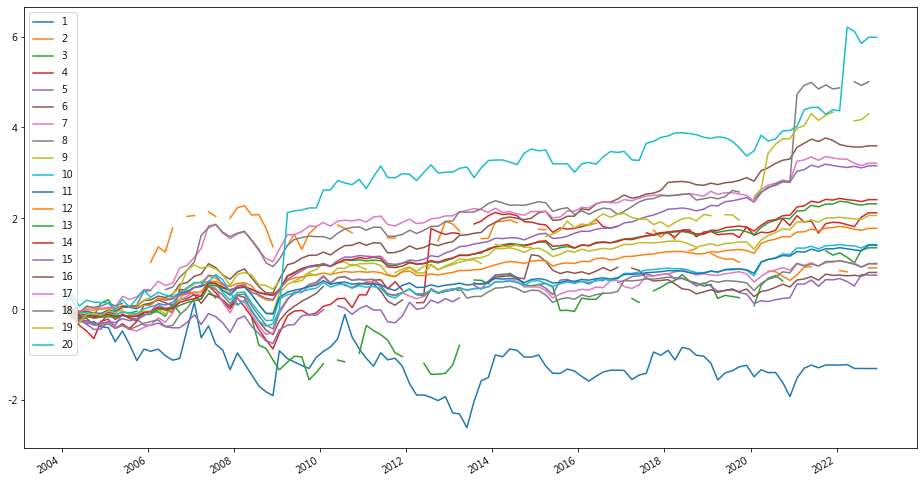

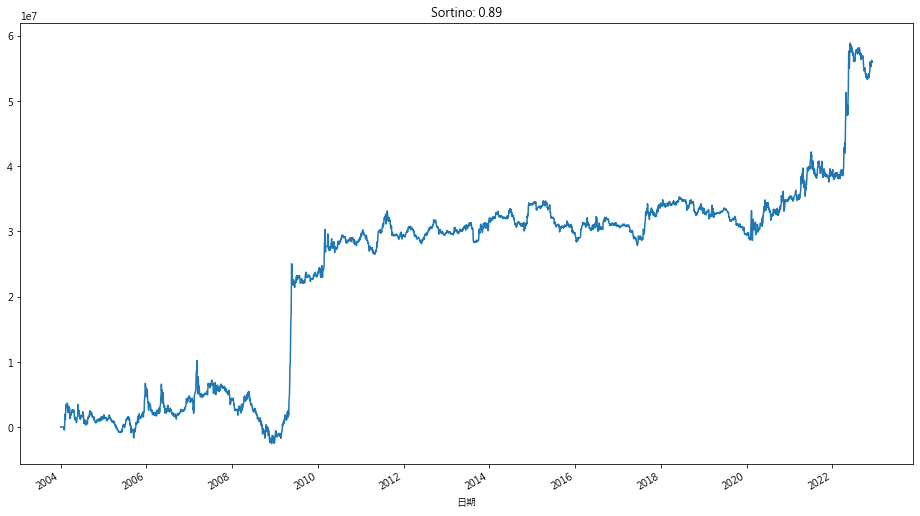

In [12]:
df_value = calculate_value(
    df=df, dic=dic, data_list=data_list, 
    reverse_list=reverse_list, stk_len=stk_len, stk_num=stk_num)
scores = calculate_scores(
    df_value=df_value, stk_idx=stk_idx, stk_num=stk_num, **best_param)

bs, sortino = backtesting(df, scores=scores, bins=20, stk_idx=stk_idx, stk_num=stk_num, freq='2M', init_cash=10000000, pplot=True, ls='onlylong', returnbs=True)


In [12]:
print(bs.iloc[-10:].loc[:, bs.iloc[-1][bs.iloc[-1] >= 1].index])
(bs * df['還原收盤價'].pct_change().shift(-2)).iloc[-10:].loc[:, '2707']

            2707
日期              
2022-11-22     0
2022-11-23     0
2022-11-24     0
2022-11-25     0
2022-11-28     0
2022-11-29     0
2022-11-30    42
2022-12-01    39
2022-12-02    38
2022-12-05    39


日期
2022-11-22    0.0000
2022-11-23    0.0000
2022-11-24    0.0000
2022-11-25    0.0000
2022-11-28    0.0000
2022-11-29    0.0000
2022-11-30    0.8235
2022-12-01   -0.8250
2022-12-02       NaN
2022-12-05       NaN
Name: 2707, dtype: float64

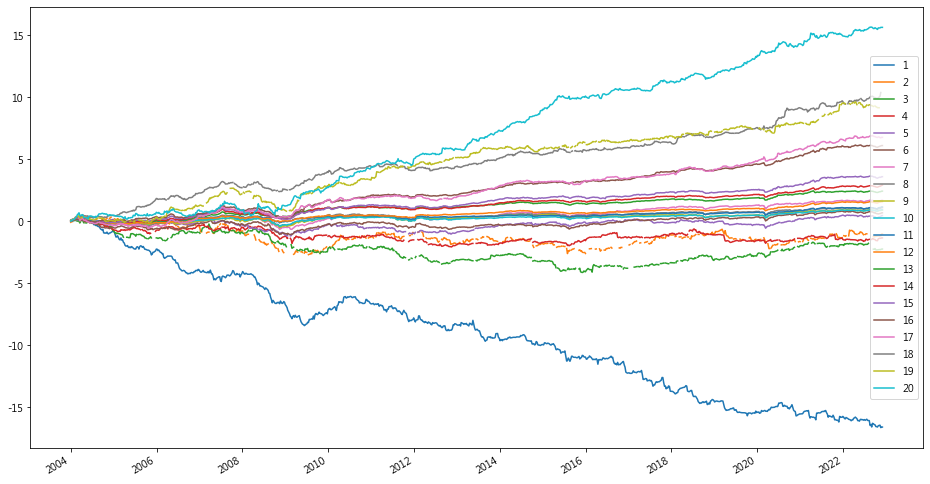

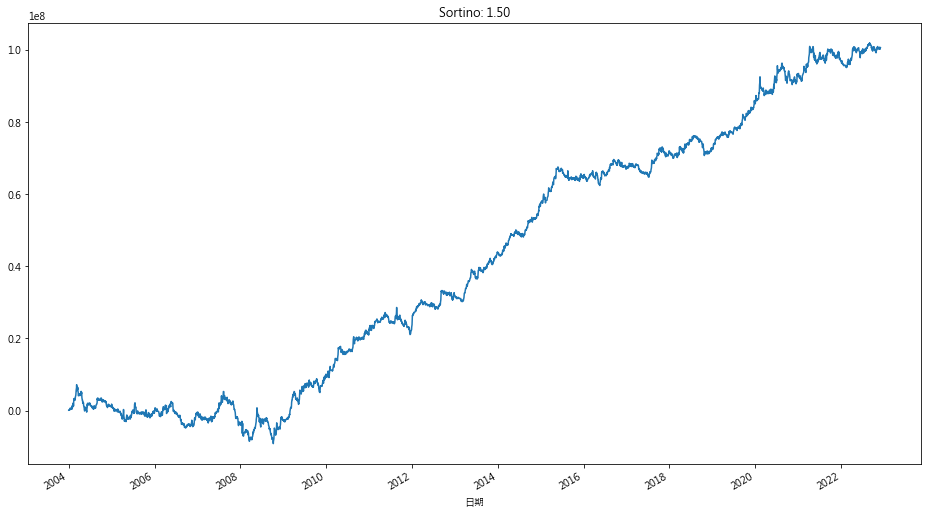

In [11]:
df_value = calculate_value(
    df=df, dic=dic, data_list=data_list, 
    reverse_list=reverse_list, stk_len=stk_len, stk_num=stk_num)
scores = calculate_scores(
    df_value=df_value, stk_idx=stk_idx, stk_num=stk_num, **best_param)

sortino = backtesting(df, scores=scores, bins=20, stk_idx=stk_idx, stk_num=stk_num, freq='W', init_cash=10000000, pplot=True, ls='onlylong')


###### 暫停，下一步是將這策略的損益計算等方式，改變成實際金額、買賣張數，藉此思考真正交易時後會產生的損益圖與成本（完美的每日balance會增加許多成本）

### 單一Sector測試

Data TWA00 has shape (6046, 34)
Data 指數彙編 has shape (2211, 8)
Data 指數名稱轉換 has shape (1, 22)
Data 本益比(近四季) has shape (4668, 133)
Data 股價淨值比 has shape (4668, 133)
Data 成交金額(千) has shape (4668, 133)
Data 還原收盤價 has shape (4668, 133)
Data EPS_Q has shape (76, 133)
Data 營業收入淨額_Q has shape (76, 133)
Data 殖利率 has shape (4668, 133)
Data 總市值(億) has shape (4668, 133)
Data 總市值(億) has shape (4668, 2211)


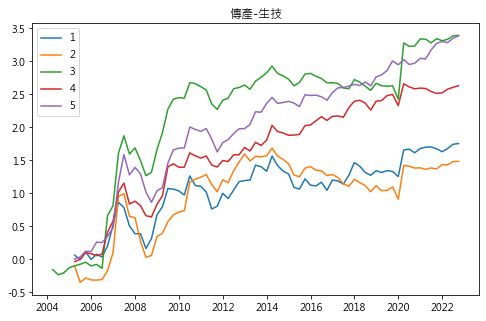

In [ ]:
data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價',
             'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime.today()
data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
dic = feed.get_from_mongo(elements=data2_list, db='Index')
sname = '傳產-生技'
symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0]
                      == sname].iloc[:, -2].astype(str).values

params = {
    'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '本益比(近四季)': '.mask(data>100, 100)',
    '殖利率': '.mask(data>100, 100)'
}
df = feed.get_from_mongo(
    elements=data_list,
    db='Fields',
    symbols=symbols,
    start=start,
    end=end,
    concat=True,
    ffill=['EPS_Q', '營業收入淨額_Q'],
    zscore=['本益比(近四季)', '股價淨值比', 'EPS_Q', '營業收入淨額_Q', '殖利率'],
    **params)

cap_all = feed.get_from_mongo(
    elements=['總市值(億)'],
    db='Fields',
    start=start,
    end=end,
    concat=True)

idx = df['還原收盤價'].dropna(how='all', axis=0).index
df = df.loc[idx]
w1 = w2 = w3 = w4 = w5 = w6 = w7 = 1.0
scores = (w1*(df['還原收盤價'] > df['還原收盤價'].rolling(120).mean()).astype(int).replace(0, -1)) + \
    (w2*(df['還原收盤價'] > df['還原收盤價'].rolling(60).mean()).astype(int).replace(0, -1)) + \
    (w3*(df['EPS_Q'].mask(df['EPS_Q'] > 0, 1).mask(df['EPS_Q'] < 0, -1))) + \
    (w4*(df['營業收入淨額_Q'].mask(df['營業收入淨額_Q'] > 0, 1).mask(df['營業收入淨額_Q'] < 0, -1))) + \
    (w5*(df['殖利率'].mask(df['殖利率'] > 0, 1).mask(df['殖利率'] < 0, -1))) + \
    (w6*-1*(df['本益比(近四季)'].mask(df['本益比(近四季)'] > 0, 1).mask(df['本益比(近四季)'] < 0, -1))) + \
    (w7*-1*(df['股價淨值比'].mask(df['股價淨值比'] > 0, 1).mask(df['股價淨值比'] < 0, -1)))

number = 500 * df['總市值(億)'].sum(axis=1)/cap_all.sum(axis=1)
number = number.mask(number < 1, 1).round(0).astype(int)
number

rt = df['還原收盤價'].loc[scores.groupby(pd.Grouper(
    freq='Q')).tail(1).index].pct_change().shift(-1)
df_long = pd.DataFrame()
df_short = pd.DataFrame()
df = list()
labels = [str(i) for i in range(1, 6)]
for k, v in scores.groupby(pd.Grouper(freq='Q')).tail(1).fillna(0).iterrows():
    length = int(len(v) / 10)
    if length == 0:
        length = 1
    se = rt.loc[k].groupby(pd.cut(v, bins=5, labels=labels)).mean()
    df.append(se)
    # l = rt.loc[k, v.sort_values().dropna()[-5:-3].index].mean()
    # s = -1 * rt.loc[k, v.sort_values().dropna()[3:5].index].mean()
    # df_long = pd.concat([df_long, pd.Series({k :l})], axis=0)
    # df_short = pd.concat([df_short, pd.Series({k :s})], axis=0)

df = pd.concat(df, axis=1).T
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df.cumsum(), label=df.columns)
ax.set_title(sname)
ax.legend()
plt.show()
# df_long.cumsum().plot()
# df_short.cumsum().plot(color='green')
# (df_long.cumsum() + df_short.cumsum()).plot(color='grey')


全部Sector測試

In [ ]:
import random

data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價',
             'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime(2017, 1, 1)
data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
dic = feed.get_from_mongo(elements=data2_list, db='Index')
cap_all = feed.get_from_mongo(
    elements=['總市值(億)'],
    db='Fields',
    start=start,
    end=end,
    pprint=False,
    concat=True)
params = {
    'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '本益比(近四季)': '.mask(data>100, 100)',
    '殖利率': '.mask(data>100, 100)'
}

sr_ = list()
loss = 1
loss_old = 1
loss_diff = 0.95
w1 = w2 = w3 = w4 = w5 = w6 = w7 = 1.0
w1_ = w2_ = w3_ = w4_ = w5_ = w6_ = w7_ = 1.0
labels = [str(i) for i in range(1, 21)]
print(f'Epochs:   Ws  MA120 MA60 EPS  營業收入 殖利率 本益比 股價淨值比 ST')
for _ in range(0, 200):
    results = dict()
    loss_old = loss
    r = np.random.randint(1, 8)
    r_ = list(range(1, 8))
    r_.remove(r)
    r1 = random.choice(r_)
    r_.remove(r1)
    r2 = random.choice(r_)
    w1_ = w1
    w2_ = w2
    w3_ = w3
    w4_ = w4
    w5_ = w5
    w6_ = w6
    w7_ = w7
    if _ > 0:
        exec('w'+str(r) + ' *= 0.99')
        exec('w'+str(r1) + ' *= 0.99')
        exec('w'+str(r2) + ' *= 0.99')
        exec('w'+str(r)+'_ = w'+str(r)+' * loss_diff**3')
        exec('w'+str(r1)+'_ = w'+str(r1)+' * loss_diff**3')
        exec('w'+str(r2)+'_ = w'+str(r2)+' * loss_diff**3')

    for sname in dic['指數彙編'].iloc[:, 0].unique():
        try:
            symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0]
                                  == sname].iloc[:, -2].astype(str).values

            df = feed.get_from_mongo(
                elements=data_list,
                db='Fields',
                symbols=symbols,
                start=start,
                end=end,
                concat=True,
                ffill=['EPS_Q', '營業收入淨額_Q'],
                zscore=['本益比(近四季)', '股價淨值比', 'EPS_Q', '營業收入淨額_Q', '殖利率'],
                pprint=False,
                **params)

            idx = df['還原收盤價'].dropna(how='all', axis=0).index
            df = df.loc[idx]

            scores = (w1_*(df['還原收盤價'] > df['還原收盤價'].rolling(120).mean()).astype(int).replace(0, -1)) + \
                (w2_*(df['還原收盤價'] > df['還原收盤價'].rolling(60).mean()).astype(int).replace(0, -1)) + \
                (w3_*(df['EPS_Q'].mask(df['EPS_Q'] > 0, 1).mask(df['EPS_Q'] < 0, -1))) + \
                (w4_*(df['營業收入淨額_Q'].mask(df['營業收入淨額_Q'] > 0, 1).mask(df['營業收入淨額_Q'] < 0, -1))) + \
                (w5_*(df['殖利率'].mask(df['殖利率'] > 0, 1).mask(df['殖利率'] < 0, -1))) + \
                (w6_*-1*(df['本益比(近四季)'].mask(df['本益比(近四季)'] > 0, 1).mask(df['本益比(近四季)'] < 0, -1))) + \
                (w7_*-1*(df['股價淨值比'].mask(df['股價淨值比']
                                          > 0, 1).mask(df['股價淨值比'] < 0, -1)))

            rt = df['還原收盤價'].loc[scores.groupby(pd.Grouper(
                freq='Q')).tail(1).index].pct_change().shift(-1)

            se_list = list()
            for k, v in scores.groupby(pd.Grouper(freq='Q')).tail(1).fillna(0).iterrows():
                length = int(len(v) / 10)
                if length == 0:
                    length = 1
                se = rt.loc[k].groupby(
                    pd.cut(v, bins=20, labels=labels)).mean()
                se_list.append(se)
            result = pd.concat(se_list, axis=1).T
            # result.fillna(0).cumsum().plot(title=sname, legend=True, figsize=(8, 5))
            # plt.show()
            # print((np.sqrt(4) * result.rolling(4).mean() / result.rolling(4).std()).mean())
            results[sname] = result

        except Exception as e:
            print(f'Error happend in {sname}', e)
    sr = list()
    for k, v in results.items():
        g = v.loc[:, '20']  # - v.loc[:, '1']
        mean = g.mean() * 4
        std = g[g < 0].std() * np.sqrt(4)
        sr.append((mean/std))
        #sr.append((np.sqrt(4) * g.rolling(4).mean() / g.rolling(4).std()).mean())

    loss = 1 / np.nanmean(sr)
    loss_diff = loss/loss_old
    if _ == 0:
        sr_.append(np.nanmean(sr))
        loss_diff = 0.95
    else:
        if np.nanmean(sr) > sr_[-1]:
            exec('w'+str(r)+' = w'+str(r)+'_')
            exec('w'+str(r1)+' = w'+str(r1)+'_')
            exec('w'+str(r2)+' = w'+str(r2)+'_')
        sr_.append(np.nanmean(sr))
    print(f'Epochs: {_} W_s = w1_={w1_:.2f}; w2_={w2_:.2f}; w3_={w3_:.2f}; w4_={w4_:.2f}; w5_={w5_:.2f}; w6_={w6_:.2f}; w7_={w7_:.2f}  st: {np.nanmean(sr):.4f} {len(sr_)}')
    print(
        f'         Ws = {w1:.2f} {w2:.2f} {w3:.2f}    {w4:.2f}  {w5:.2f}  {w6:.2f}  {w7:.2f}  st: {np.nanmean(sr):.4f} {len(sr_)}')


Data TWA00 has shape (6047, 34)
Data 指數彙編 has shape (2211, 8)
Data 指數名稱轉換 has shape (1, 22)
Epochs:   Ws  MA120 MA60 EPS  營業收入 殖利率 本益比 股價淨值比 ST
Epochs: 0 W_s = w1_=1.00; w2_=1.00; w3_=1.00; w4_=1.00; w5_=1.00; w6_=1.00; w7_=1.00  st: 1.2138 1
         Ws = 1.00 1.00 1.00    1.00  1.00  1.00  1.00  st: 1.2138 1
Epochs: 1 W_s = w1_=0.85; w2_=0.85; w3_=1.00; w4_=1.00; w5_=1.00; w6_=1.00; w7_=0.85  st: 1.1864 2
         Ws = 0.99 0.99 1.00    1.00  1.00  1.00  0.99  st: 1.1864 2
Epochs: 2 W_s = w1_=1.05; w2_=0.99; w3_=1.00; w4_=1.06; w5_=1.06; w6_=1.00; w7_=0.99  st: 1.2165 3
         Ws = 1.05 0.99 1.00    1.06  1.06  1.00  0.99  st: 1.2165 3
Epochs: 3 W_s = w1_=0.96; w2_=0.91; w3_=1.00; w4_=0.97; w5_=1.06; w6_=1.00; w7_=0.99  st: 1.2137 4
         Ws = 1.04 0.98 1.00    1.05  1.06  1.00  0.99  st: 1.2137 4
Epochs: 4 W_s = w1_=1.04; w2_=0.98; w3_=1.00; w4_=1.05; w5_=1.06; w6_=1.00; w7_=0.99  st: 1.2147 5
         Ws = 1.04 0.98 1.00    1.05  1.06  1.00  0.99  st: 1.2147 5
Epochs: 5 W_s = 

In [ ]:
print(f'Epochs: {_} W_s = w1_={w1_:.2f}; w2_={w2_:.2f}; w3_={w3_:.2f}; w4_={w4_:.2f}; w5_={w5_:.2f}; w6_={w6_:.2f}; w7_={w7_:.2f}  st: {np.nanmean(sr):.4f} {len(sr_)}')


Epochs: 199 W_s = w1_=0.49; w2_=0.48; w3_=0.50; w4_=0.55; w5_=0.60; w6_=0.50; w7_=0.53  st: 1.2431 200


In [ ]:
import random

data_list = ['本益比(近四季)', '股價淨值比', '成交金額(千)', '還原收盤價',
             'EPS_Q', '營業收入淨額_Q', '殖利率', '總市值(億)']
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime.today()
data2_list = ['TWA00', '指數彙編', '指數名稱轉換']
dic = feed.get_from_mongo(elements=data2_list, db='Index')
cap_all = feed.get_from_mongo(
    elements=['總市值(億)'],
    db='Fields',
    start=start,
    end=end,
    pprint=False,
    concat=True)
params = {
    'EPS_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '營業收入淨額_Q': '.rolling(4).sum().pct_change().replace([np.inf, -np.inf], 0)',
    '本益比(近四季)': '.mask(data>100, 100)',
    '殖利率': '.mask(data>100, 100)'
}

sr_ = list()
long = dict()
short = dict()
#w1_=0.84; w2_=0.82; w3_=0.94; w4_=0.90;  w5_=0.80;  w6_=1.15;  w7_=1.36
w1_ = 0.49
w2_ = 0.48
w3_ = 0.50
w4_ = 0.55
w5_ = 0.60
w6_ = 0.50
w7_ = 0.53
labels = [str(i) for i in range(1, 21)]
for sname in dic['指數彙編'].iloc[:, 0].unique():
    try:
        symbols = dic['指數彙編'][dic['指數彙編'].iloc[:, 0]
                              == sname].iloc[:, -2].astype(str).values

        df = feed.get_from_mongo(
            elements=data_list,
            db='Fields',
            symbols=symbols,
            start=start,
            end=end,
            concat=True,
            ffill=['EPS_Q', '營業收入淨額_Q'],
            zscore=['本益比(近四季)', '股價淨值比', 'EPS_Q', '營業收入淨額_Q', '殖利率'],
            pprint=False,
            **params)

        idx = df['還原收盤價'].dropna(how='all', axis=0).index
        df = df.loc[idx]

        scores = (w1_*(df['還原收盤價'] > df['還原收盤價'].rolling(120).mean()).astype(int).replace(0, -1)) + \
            (w2_*(df['還原收盤價'] > df['還原收盤價'].rolling(60).mean()).astype(int).replace(0, -1)) + \
            (w3_*(df['EPS_Q'].mask(df['EPS_Q'] > 0, 1).mask(df['EPS_Q'] < 0, -1))) + \
            (w4_*(df['營業收入淨額_Q'].mask(df['營業收入淨額_Q'] > 0, 1).mask(df['營業收入淨額_Q'] < 0, -1))) + \
            (w5_*(df['殖利率'].mask(df['殖利率'] > 0, 1).mask(df['殖利率'] < 0, -1))) + \
            (w6_*-1*(df['本益比(近四季)'].mask(df['本益比(近四季)'] > 0, 1).mask(df['本益比(近四季)'] < 0, -1))) + \
            (w7_*-1*(df['股價淨值比'].mask(df['股價淨值比']
                                      > 0, 1).mask(df['股價淨值比'] < 0, -1)))

        rt = df['還原收盤價'].loc[scores.groupby(pd.Grouper(
            freq='M')).tail(1).index].pct_change().shift(-1)

        se_list = list()
        if len(rt.columns) > 1:
            labels = [str(i) for i in range(1, len(rt.columns))]
        else:
            labels = ['1']
        for k, v in scores.groupby(pd.Grouper(freq='M')).tail(1).fillna(0).iterrows():
            if k not in long:
                long[k] = list()
            if k not in short:
                short[k] = list()
            length = int(len(v) / 10)
            if length == 0:
                length = 1
            se = rt.loc[k].groupby(
                pd.cut(v, bins=len(labels), labels=labels)).mean()
            long[k].extend(
                v[pd.cut(v, bins=len(labels), labels=labels) == labels[-1]].index)
            short[k].extend(
                v[pd.cut(v, bins=len(labels), labels=labels) == labels[0]].index)
            se_list.append(se)
        result = pd.concat(se_list, axis=1).T
        # result.fillna(0).cumsum().plot(title=sname, legend=True, figsize=(8, 5))
        # plt.show()
        results[sname] = result

    except Exception as e:
        print(f'Error happend in {sname}', e)
# sr = list()
# for k, v in results.items():
# 	g = v.loc[:, '5'] - v.loc[:, '1']
# 	mean = g.mean() * 12
# 	std = g[g<0].std() * np.sqrt(12)
# 	sr.append((mean/std))
    #sr.append((np.sqrt(4) * g.rolling(4).mean() / g.rolling(4).std()).mean())


Data TWA00 has shape (6048, 34)
Data 指數彙編 has shape (2211, 8)
Data 指數名稱轉換 has shape (1, 22)


In [ ]:
pf = pd.DataFrame()
for k, v in results.items():
    if len(v.columns) > 1:
        se = v.iloc[:, 0]  # - v.loc[:, '10']
    else:
        se = v.iloc[:, 0]
    se.name = k
    pf = pd.concat([pf, se], axis=1)


In [ ]:
pf_ = pd.DataFrame()
for i in range(1, 21):
    pf = pd.DataFrame()
    for k, v in results.items():
        se = v.loc[:, str(i)]  # - v.loc[:, '10']
        se.name = k
        pf = pd.concat([pf, se], axis=1)
    pf = pf.mean(axis=1)
    pf.name = str(i)
    pf_ = pd.concat([pf_, pf], axis=1)


KeyError: '2'

<AxesSubplot: >

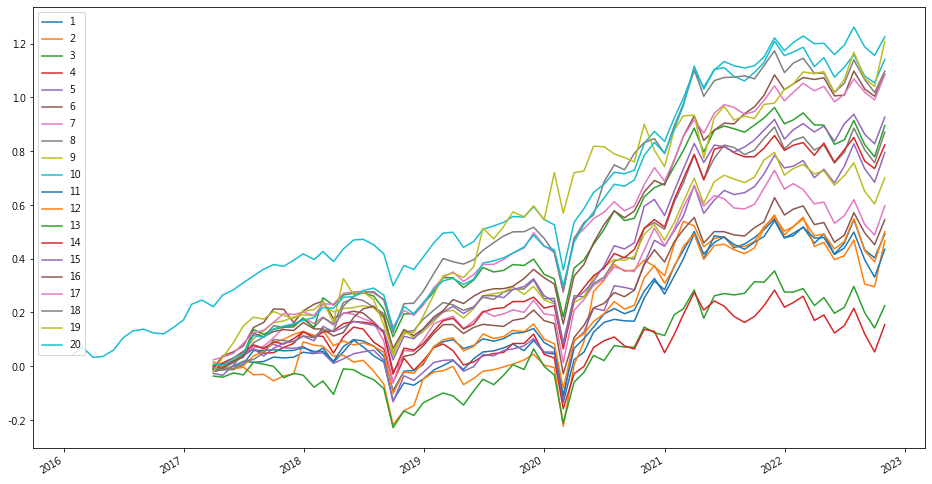

In [ ]:
pf_.cumsum().plot(figsize=(16, 9))


<AxesSubplot: >

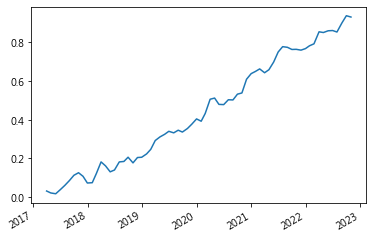

In [ ]:
(pf_['17'] - pf_['4']).cumsum().plot()


In [ ]:
for k, v in short.items():
    print(k, len(v))


2016-01-30 00:00:00 4
2016-02-26 00:00:00 4
2016-03-31 00:00:00 4
2016-04-29 00:00:00 4
2016-05-31 00:00:00 4
2016-06-30 00:00:00 4
2016-07-29 00:00:00 4
2016-08-31 00:00:00 4
2016-09-30 00:00:00 4
2016-10-31 00:00:00 4
2016-11-30 00:00:00 4
2016-12-30 00:00:00 4
2017-01-24 00:00:00 4
2017-02-24 00:00:00 4
2017-03-31 00:00:00 122
2017-04-28 00:00:00 119
2017-05-31 00:00:00 121
2017-06-30 00:00:00 113
2017-07-31 00:00:00 111
2017-08-31 00:00:00 111
2017-09-30 00:00:00 113
2017-10-31 00:00:00 115
2017-11-30 00:00:00 127
2017-12-29 00:00:00 110
2018-01-31 00:00:00 115
2018-02-27 00:00:00 135
2018-03-31 00:00:00 121
2018-04-30 00:00:00 131
2018-05-31 00:00:00 129
2018-06-29 00:00:00 128
2018-07-31 00:00:00 110
2018-08-31 00:00:00 113
2018-09-28 00:00:00 118
2018-10-31 00:00:00 123
2018-11-30 00:00:00 119
2018-12-28 00:00:00 109
2019-01-30 00:00:00 106
2019-02-27 00:00:00 113
2019-03-29 00:00:00 111
2019-04-30 00:00:00 122
2019-05-31 00:00:00 111
2019-06-28 00:00:00 117
2019-07-31 00:00:00 

In [ ]:
Epochs: 32 Ws = 0.39 0.46 0.43 0.31 0.49 0.26 0.50 sr: 0.5193
Ws = 0.84 0.82 0.94    0.90  0.80  1.15  1.36
